In [76]:
from power_spectra import *
from scipy.special import jn, jn_zeros
from scipy.interpolate import interp1d
from hankel_transform import *
from astropy.cosmology import Planck13 #use Planck15 if you can
import astropy.units as u
rc('text', usetex=False)
import scipy
from scipy.interpolate import interp1d

In [2]:
cosmo=Planck13.clone()#we want h=1 for some comparisons

In [3]:
cosmo.Ob0

0.048252

In [95]:
kmax=30
kmin=.8e-3
k_smooth=1
nk=5000
rmin=1
rmax=50
non_linear=1

In [10]:
cosmo_fid=dict({'h':cosmo.h,'Omb':cosmo.Ob0,'Omd':cosmo.Om0-cosmo.Ob0,'s8':0.817,'Om':cosmo.Om0,
                'As':2.12e-09,'mnu':cosmo.m_nu[-1].value,'Omk':cosmo.Ok0,'tau':0.06,'ns':0.965,'w':-1,'wa':0})
pk_params={'non_linear':non_linear,'kmax':kmax,'kmin':kmin,'nk':nk}

In [11]:
PS=Power_Spectra(cosmo_params=cosmo_fid,pk_params=pk_params)

In [69]:
z=[0.1,0.2]
pk,kh =PS.class_pk(z=z)

In [96]:
#Setting up the Hankel Transform
#This part is slower. But only needs to be run once. 
#If you only need wgg, set j_nu=[0]. For wg+ (or \Delta\Sigma) use j_nu=[2]
%time HT=hankel_transform(rmin=rmin,rmax=rmax,kmax=kmax,j_nu=[0,2,4],n_zeros=28000,kmin=kmin)
#HT=hankel_transform(rmin=1,rmax=rmax,kmax=1,j_nu=[0,2],n_zeros=2800,kmin=1.e-2)#quick test... inaccurate

j-nu= 0  not enough zeros to cover kmin, increasing by  1000  to 29000
nr: 470
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 29000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 30000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 31000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 32000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 33000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 34000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 35000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 36000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 37000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 38000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 39000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 40000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 4100

In [97]:
pk_taper=HT.taper(k=kh,pk=pk[0],large_k_lower=5,large_k_upper=kmax,low_k_lower=kmin,
                     low_k_upper=kmin*2)
#need atleast k=10 and k=1.e-3 to get decent wgg for 1-100 Mpc/h range.

In [98]:
from scipy.integrate import quad as scipy_int1d

In [99]:
cosmo.H(z=[0]).value

array([67.74])

In [100]:
def DZ_int(z=[0],cosmo=None,rtol=1.e-4,tol=1.e-5): #linear growth factor.. full integral.. eq 63 in Lahav and suto
        Ez_func=cosmo.efunc
        def intf(z):
            return (1.+z)/(cosmo.H(z=z).value**3)
        dz=np.zeros_like(z,dtype='float32')
        inf=np.inf
        j=0
        for i in z:
            dz[j]+=cosmo.H(i).value*scipy_int1d(intf,i,inf,epsrel=rtol,epsabs=tol)[0]
            j=j+1
        dz=dz*2.5*cosmo.Om0*cosmo.H0**2
        return dz/dz[0] #check for normalization

In [101]:
DZ_int(z=z,cosmo=cosmo)

<Quantity [1.       ,0.9485862]>

In [102]:
b_g=1.8
A_I=5
C1_rhoC=0.0134
Om=cosmo.Om0
Dz=DZ_int(z=np.append([0],z),cosmo=cosmo)# Dz is normalized to 1 at lowest z. 
                                    #Hence appending 0 in front to get Dz normalized to 1 at z=0
    
wgg_f=b_g**2
wgp_f=b_g*A_I*C1_rhoC*Om/Dz
wpp_f=(A_I*C1_rhoC*Om/Dz)**2

In [117]:
r_gg,wgg=HT.projected_correlation(k_pk=kh,pk=pk[0]*wgg_f,j_nu=0)
%time r_gg,wgg_taper=HT.projected_correlation(k_pk=kh,pk=pk_taper*wgg_f,j_nu=0)

r_gp,wgp=HT.projected_correlation(k_pk=kh,pk=pk[0]*wgp_f[0],j_nu=2)

r_pp,wpp4=HT.projected_correlation(k_pk=kh,pk=pk[0]*wpp_f[0],j_nu=4)
r_pp0,wpp0=HT.projected_correlation(k_pk=kh,pk=pk[0]*wpp_f[0],j_nu=0)

wpp0_intp=interp1d(r_pp0,wpp0,bounds_error=False,fill_value=np.nan)
wpp=wpp4+wpp0_intp(r_pp)

CPU times: user 20.5 ms, sys: 245 µs, total: 20.8 ms
Wall time: 9.17 ms


/Users/Deep/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


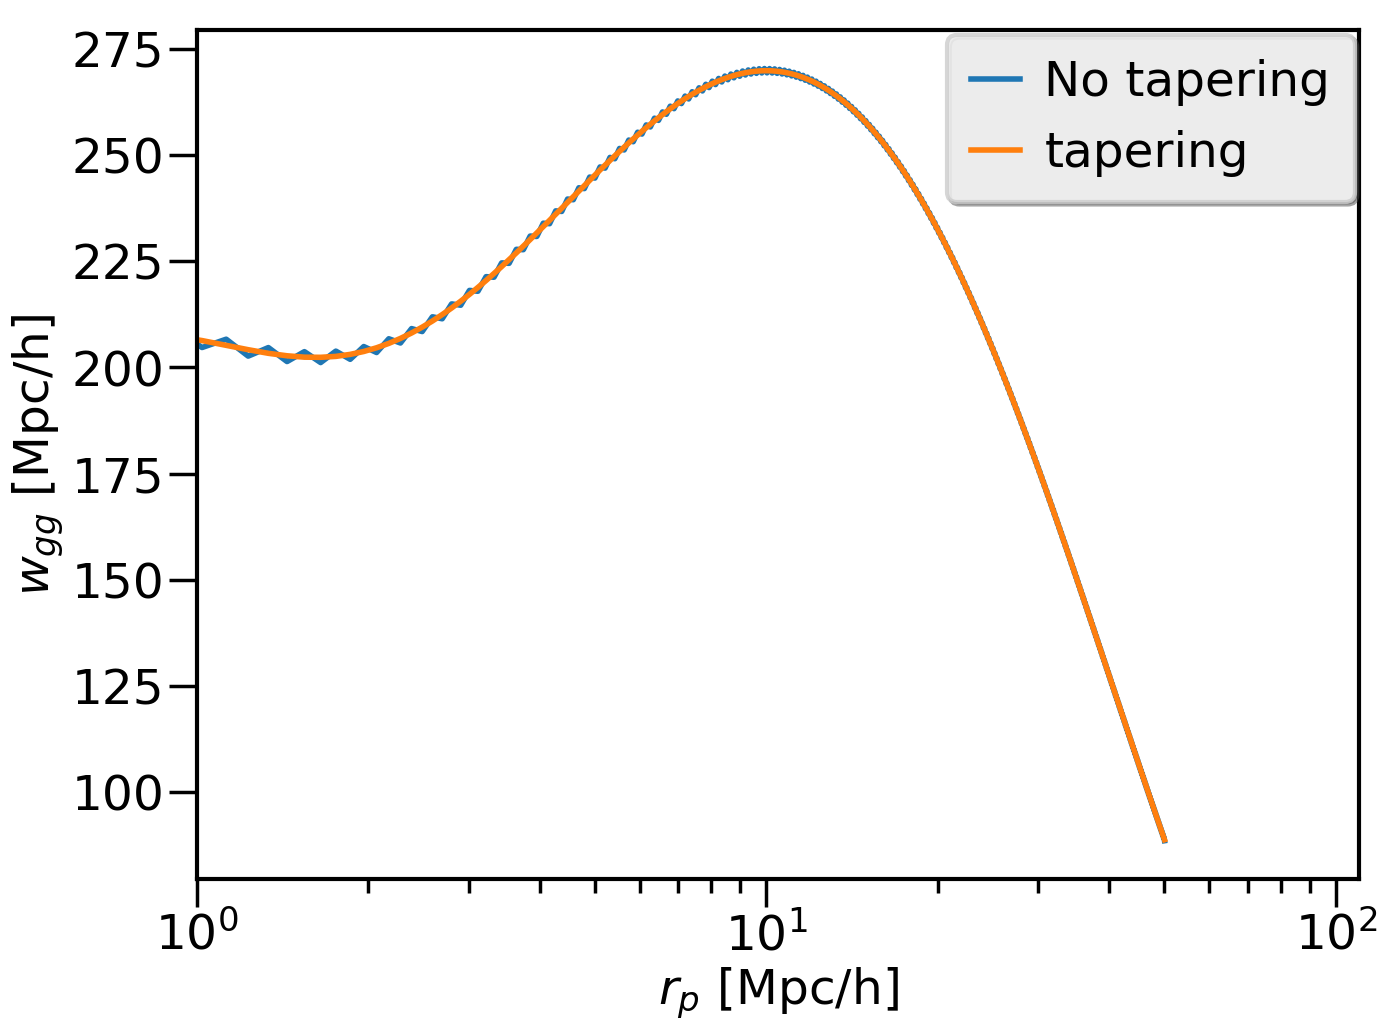

In [113]:
plot(r_gg,r_gg*wgg,label='No tapering')
plot(r_gg,r_gg*wgg_taper,label='tapering')
#plot(wgg_test['rp'],wgg_test['rp']*wgg_test['wgg']*wgg_test_fact)
xscale('log')
#yscale('log')
#ylim(1.e-2,1.e3)
xlim(1,110)
xlabel('$r_p$ [Mpc/h]')
ylabel('$w_{gg}$ [Mpc/h]')

legend()

/Users/Deep/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


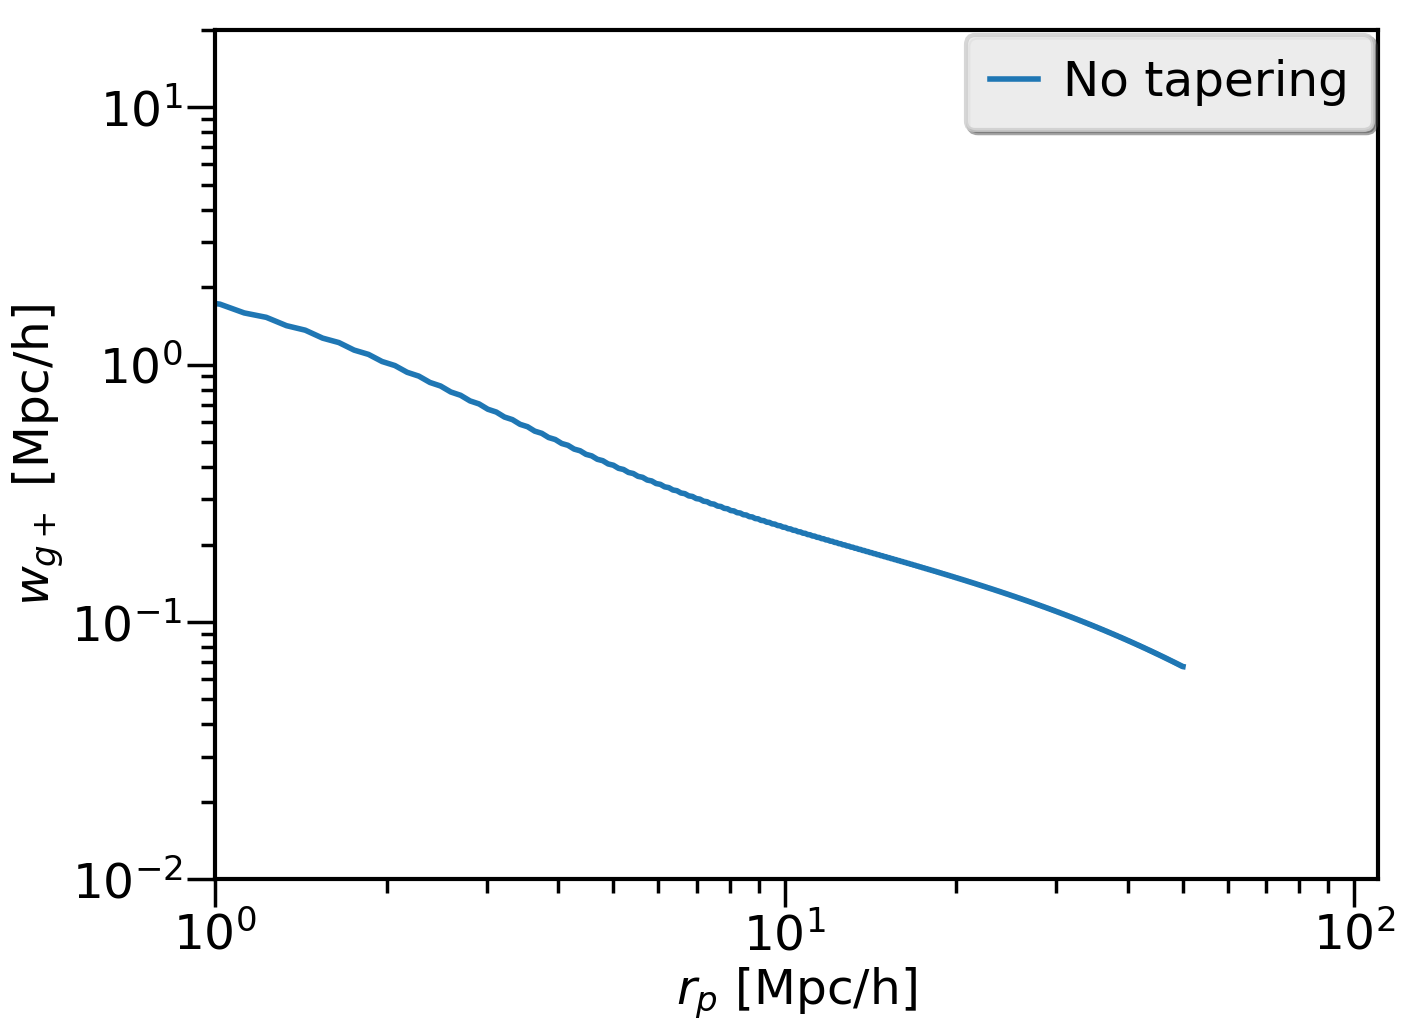

In [114]:
plot(r_gp,wgp,label='No tapering')
xscale('log')
yscale('log')
xlim(1,110)
xlabel('$r_p$ [Mpc/h]')
ylabel('$w_{g+}$ [Mpc/h]')
ylim(1.e-2,20)
legend()

/Users/Deep/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


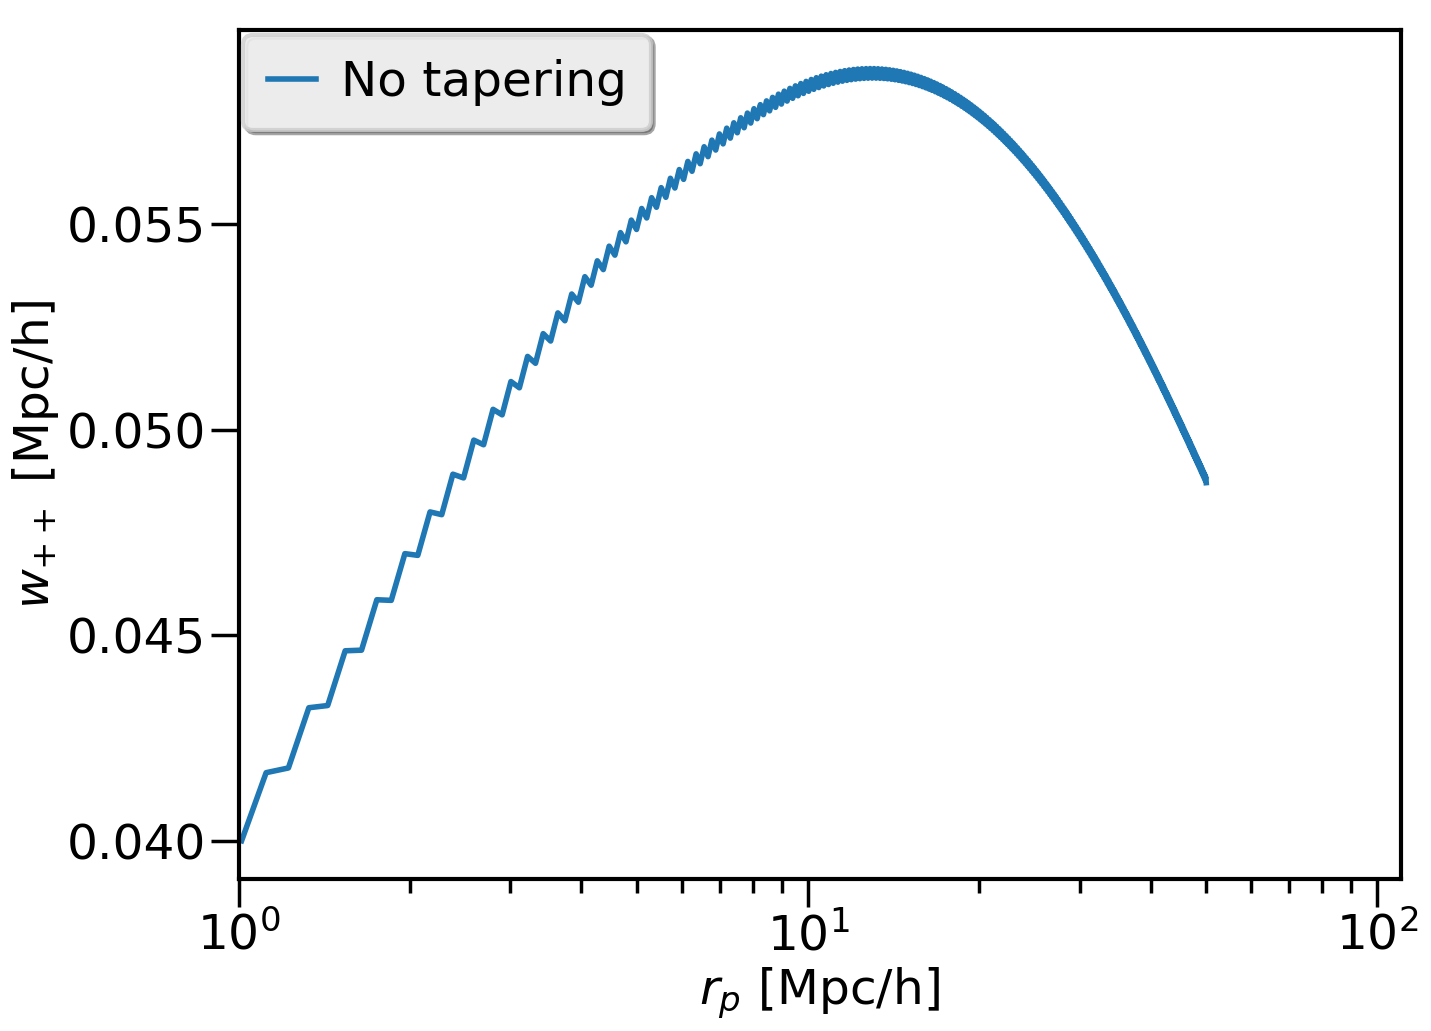

In [119]:
plot(r_pp,r_pp*wpp,label='No tapering')
xscale('log')
xlim(1,110)
xlabel('$r_p$ [Mpc/h]')
ylabel('$w_{++}$ [Mpc/h]')
# ylim(0,72)
legend()

Text(0.5,0,'$r_p$ [Mpc/h]')

/Users/Deep/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


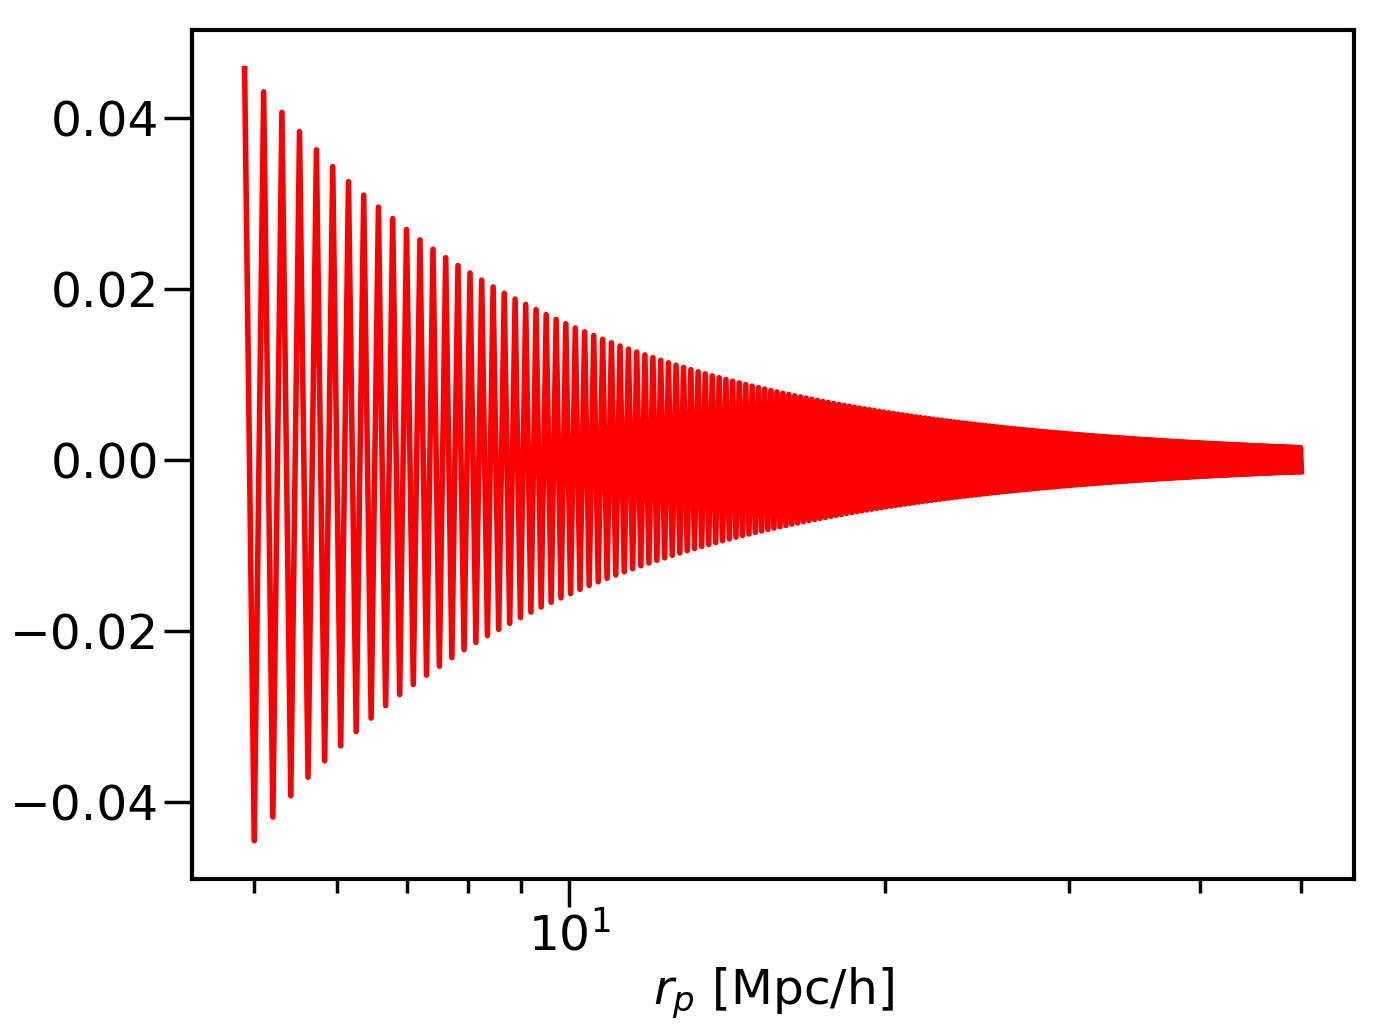

In [81]:
plot(r_gg,wgg-wgg_taper,'r')
xscale('log')
xlabel('$r_p$ [Mpc/h]')